## Import Required Packages

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
import seaborn as sns

import random

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical # pip install git+https://github.com/tensorflow/addons.git
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, TimeDistributed, Dense
from tensorflow_addons.layers import CRF
from tensorflow_addons.optimizers import AdamW
from tensorflow_addons.losses import SigmoidFocalCrossEntropy

from gensim.models import Word2Vec
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix


2024-12-27 13:51:53.452705: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-27 13:51:53.474128: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-27 13:51:53.581189: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-27 13:51:53.581228: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-27 13:51:53.581856: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

## Define the Problem Statement and perform Exploratory Data Analysis

### Definition of Problem


Implement Named Entity Recognition (NER) for automatic content tagging and analysis. This initiative is intended to overcome the limitations of relying on user-generated hashtags, which can be inconsistent, inaccurate, or absent. The dataset is annotated with 10 fine-grained NER categories: person, geo-location, company, facility, product, music artist, movie, sports team, TV show, and other.

In [2]:
# Check if TensorFlow is built with CUDA support
if tf.test.is_built_with_cuda():
    print("TensorFlow is built with CUDA support.")
else:
    print("TensorFlow is not built with CUDA support.")

# Check if a GPU is available and visible
if tf.config.list_physical_devices('GPU'):
    print("CUDA is available.")
else:
    print("CUDA is not available.")

TensorFlow is built with CUDA support.
CUDA is not available.


2024-12-27 13:51:57.046539: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2024-12-27 13:51:57.046561: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: varun
2024-12-27 13:51:57.046565: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: varun
2024-12-27 13:51:57.046707: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 550.120.0
2024-12-27 13:51:57.046719: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 550.120.0
2024-12-27 13:51:57.046722: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:309] kernel version seems to match DSO: 550.120.0


In [3]:
# Hyperparams if GPU is available
if tf.test.is_gpu_available():
    BATCH_SIZE = 512  # Number of examples used in each iteration
    EPOCHS = 5  # Number of passes through entire dataset
    MAX_LEN = 75  # Max length of review (in words)
    EMBEDDING = 40  # Dimension of word embedding vector
    
# Hyperparams for CPU training
else:
    BATCH_SIZE = 32
    EPOCHS = 5
    MAX_LEN = 75
    EMBEDDING = 20

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


In [4]:
BATCH_SIZE

32

## Data Preprocessing

### Data Cleaning and Formatting

In [5]:
def read_conll(file_path):
    sentences = []
    sentence = []

    with open(file_path, 'r') as file:
        for line in file:
            line = line.strip()

            if line:
                token, tag = line.split('\t')
                sentence.append((token, tag))
            else:
                if sentence:
                    sentences.append(sentence)
                    sentence = []

    return sentences

In [6]:
file_path = "dataset/wnut 16.txt.conll"
data  = read_conll(file_path)
 
data[0]

[('@SammieLynnsMom', 'O'),
 ('@tg10781', 'O'),
 ('they', 'O'),
 ('will', 'O'),
 ('be', 'O'),
 ('all', 'O'),
 ('done', 'O'),
 ('by', 'O'),
 ('Sunday', 'O'),
 ('trust', 'O'),
 ('me', 'O'),
 ('*wink*', 'O')]

In [7]:
len(data)

2393

### Data Transformation for NER

In [8]:
# Convert to a DataFrame if needed
df = pd.DataFrame([(token, tag) for value in data for token, tag in value], columns=['Token', 'Tag'])
print(df.head())

             Token Tag
0  @SammieLynnsMom   O
1         @tg10781   O
2             they   O
3             will   O
4               be   O


### EDA

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46462 entries, 0 to 46461
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Token   46462 non-null  object
 1   Tag     46462 non-null  object
dtypes: object(2)
memory usage: 726.1+ KB


In [10]:
df.shape

(46462, 2)

In [11]:
print("Number of sentences: ", len(data))

Number of sentences:  2393


In [12]:
print("Number of labels", df["Tag"].nunique())

Number of labels 21


In [13]:
print("Frequency of labels", df["Tag"].value_counts())

Frequency of labels Tag
O                44000
B-person           449
I-other            320
B-geo-loc          276
B-other            225
I-person           215
B-company          171
I-facility         105
B-facility         104
B-product           97
I-product           80
I-musicartist       61
B-musicartist       55
B-sportsteam        51
I-geo-loc           49
I-movie             46
I-company           36
B-movie             34
B-tvshow            34
I-tvshow            31
I-sportsteam        23
Name: count, dtype: int64


In [14]:
senteces_length = [len(s) for s in data]

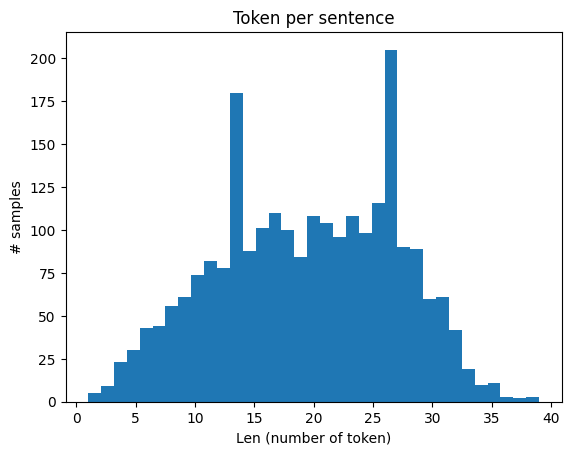

In [15]:
# Plot sentence by lenght
plt.hist(senteces_length, bins=35)
plt.title('Token per sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

From the histogram, we can see most of the sentences have around <b> 15 to 30 tokens </b>. Tokens can we referred as words ignoring punctuation marks.

<Axes: >

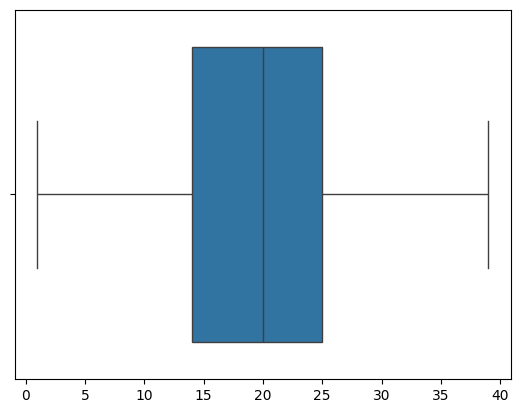

In [16]:
sns.boxplot(x = senteces_length)

### Handling Sparse Data

In [17]:
df.head()

,Token,Tag
0,@SammieLynnsMom,O
1,@tg10781,O
2,they,O
3,will,O
4,be,O


In [18]:
df.Tag.value_counts()

Tag
O                44000
B-person           449
I-other            320
B-geo-loc          276
B-other            225
I-person           215
B-company          171
I-facility         105
B-facility         104
B-product           97
I-product           80
I-musicartist       61
B-musicartist       55
B-sportsteam        51
I-geo-loc           49
I-movie             46
I-company           36
B-movie             34
B-tvshow            34
I-tvshow            31
I-sportsteam        23
Name: count, dtype: int64

In [19]:
df["entity"] = df["Tag"].apply(lambda x : x.split("-")[-1] if len(x.split("-")) > 1 else "")

In [20]:
df.entity.value_counts()

entity
               44000
person           664
other            545
loc              325
facility         209
company          207
product          177
musicartist      116
movie             80
sportsteam        74
tvshow            65
Name: count, dtype: int64

In [21]:
lowcount_labels = df.entity.value_counts().iloc[3:].reset_index().entity.tolist()

In [22]:
for ele in data[:5]:
    print(ele)

[('@SammieLynnsMom', 'O'), ('@tg10781', 'O'), ('they', 'O'), ('will', 'O'), ('be', 'O'), ('all', 'O'), ('done', 'O'), ('by', 'O'), ('Sunday', 'O'), ('trust', 'O'), ('me', 'O'), ('*wink*', 'O')]
[('Made', 'O'), ('it', 'O'), ('back', 'O'), ('home', 'O'), ('to', 'O'), ('GA', 'B-geo-loc'), ('.', 'O'), ('It', 'O'), ('sucks', 'O'), ('not', 'O'), ('to', 'O'), ('be', 'O'), ('at', 'O'), ('Disney', 'B-facility'), ('world', 'I-facility'), (',', 'O'), ('but', 'O'), ('its', 'O'), ('good', 'O'), ('to', 'O'), ('be', 'O'), ('home', 'O'), ('.', 'O'), ('Time', 'O'), ('to', 'O'), ('start', 'O'), ('planning', 'O'), ('the', 'O'), ('next', 'O'), ('Disney', 'B-facility'), ('World', 'I-facility'), ('trip', 'O'), ('.', 'O')]
[("'", 'O'), ('Breaking', 'B-movie'), ('Dawn', 'I-movie'), ("'", 'O'), ('Returns', 'O'), ('to', 'O'), ('Vancouver', 'B-geo-loc'), ('on', 'O'), ('January', 'O'), ('11th', 'O'), ('http://bit.ly/dbDMs8', 'O')]
[('@ls_n', 'O'), ('perhaps', 'O'), (',', 'O'), ('but', 'O'), ('folks', 'O'), ('may'

### Oversampling

In [23]:
# oversampled_data = data

In [24]:
oversampling = {}
for label in lowcount_labels:
    oversampling[label] = []
for sentence in data:
    for word, label in sentence:
        if label.split("-")[-1] in df.entity.value_counts().iloc[3:].reset_index().entity.tolist():
            oversampling[label.split("-")[-1]].append(sentence)
            break

In [25]:
for key, value in oversampling.items():
    print(key, len(value))

loc 174
facility 77
company 135
product 65
musicartist 35
movie 24
sportsteam 37
tvshow 29


In [26]:
len(data)

2393

In [27]:
oversampled_data = data + random.choices(oversampling["loc"], k=200)
oversampled_data += random.choices(oversampling["facility"], k=300)
oversampled_data += random.choices(oversampling["company"], k=300)
oversampled_data += random.choices(oversampling["product"], k=400)
oversampled_data += random.choices(oversampling["musicartist"], k=400)
oversampled_data += random.choices(oversampling["movie"], k=500)
oversampled_data += random.choices(oversampling["sportsteam"], k=500)
oversampled_data += random.choices(oversampling["tvshow"], k=500)

In [28]:
len(oversampled_data)

5493

### Tokenization and Encoding:

In [29]:
df.head()

,Token,Tag,entity
0,@SammieLynnsMom,O,
1,@tg10781,O,
2,they,O,
3,will,O,
4,be,O,


In [30]:
df["Token"].value_counts()

Token
.               1524
,                914
the              876
to               824
I                762
                ... 
shaped             1
hole               1
Def                1
tune               1
@ihatequotes       1
Name: count, Length: 10585, dtype: int64

In [31]:
words = list(set(df["Token"].values))
print("Number of unique words in the dataset: ", len(words))

Number of unique words in the dataset:  10585


In [32]:
df["Tag"].value_counts()

Tag
O                44000
B-person           449
I-other            320
B-geo-loc          276
B-other            225
I-person           215
B-company          171
I-facility         105
B-facility         104
B-product           97
I-product           80
I-musicartist       61
B-musicartist       55
B-sportsteam        51
I-geo-loc           49
I-movie             46
I-company           36
B-movie             34
B-tvshow            34
I-tvshow            31
I-sportsteam        23
Name: count, dtype: int64

In [33]:
tags = list(set(df["Tag"].values))
print("Number of Labels: ", len(tags))

Number of Labels:  21


In [34]:
tags

['I-sportsteam',
 'I-geo-loc',
 'I-musicartist',
 'B-tvshow',
 'B-geo-loc',
 'I-other',
 'I-product',
 'I-company',
 'B-product',
 'B-other',
 'B-person',
 'I-tvshow',
 'I-facility',
 'B-movie',
 'O',
 'I-movie',
 'I-person',
 'B-facility',
 'B-company',
 'B-musicartist',
 'B-sportsteam']

### Indexing my words and labels to consider them as Tokens

In [35]:
word2idx = {w:i+2 for i,w in enumerate(words)}
word2idx["UNK"] = 1
word2idx["PAD"] = 0

tag2idx = {t:i+2 for i,t in enumerate(tags)}
tag2idx["PAD"] = 0
tag2idx["UNK"] = 1

print("The word doctor is identified by the index: {}".format(word2idx["doctor"]))
print("The labels B-movie(which defines Movie Enitities at the Bengining) is identified by the index: {}".format(tag2idx["B-movie"]))

The word doctor is identified by the index: 333
The labels B-movie(which defines Movie Enitities at the Bengining) is identified by the index: 15


In [36]:
tag2idx

{'I-sportsteam': 2,
 'I-geo-loc': 3,
 'I-musicartist': 4,
 'B-tvshow': 5,
 'B-geo-loc': 6,
 'I-other': 7,
 'I-product': 8,
 'I-company': 9,
 'B-product': 10,
 'B-other': 11,
 'B-person': 12,
 'I-tvshow': 13,
 'I-facility': 14,
 'B-movie': 15,
 'O': 16,
 'I-movie': 17,
 'I-person': 18,
 'B-facility': 19,
 'B-company': 20,
 'B-musicartist': 21,
 'B-sportsteam': 22,
 'PAD': 0,
 'UNK': 1}

### Training: Data Creation

In [37]:
oversampled_data[0]

[('@SammieLynnsMom', 'O'),
 ('@tg10781', 'O'),
 ('they', 'O'),
 ('will', 'O'),
 ('be', 'O'),
 ('all', 'O'),
 ('done', 'O'),
 ('by', 'O'),
 ('Sunday', 'O'),
 ('trust', 'O'),
 ('me', 'O'),
 ('*wink*', 'O')]

In [38]:
X = [[word2idx[ele[0]] for ele in sentence] for sentence in oversampled_data]

# pad the sequences, to have same length
X = pad_sequences(
    maxlen = MAX_LEN,
    sequences = X,
    padding = "post",
    value = word2idx["PAD"]
)

print('Raw Sample:\n ', ' '.join([w[0] for w in oversampled_data[0]]))
print('\n ' )
print('After processing, sample:\n', X[0])

Raw Sample:
  @SammieLynnsMom @tg10781 they will be all done by Sunday trust me *wink*

 
After processing, sample:
 [8977 6739  116  330 6322 8426 5093  722 7062 9595 2997  147    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0]


In [39]:
# Convert my Tag/Label to tag_index
y = [[tag2idx[ele[1]] for ele in sentence] for sentence in oversampled_data]

# Padding each label to have same length
y = pad_sequences(
    maxlen = MAX_LEN,
    sequences = y,
    padding = "post",
    value = tag2idx["PAD"]
)

print('Raw Label:\n ', ' '.join([w[1] for w in oversampled_data[0]]))
print('\n ' )
print('After processing, labels:\n', y[0])

Raw Label:
  O O O O O O O O O O O O

 
After processing, labels:
 [16 16 16 16 16 16 16 16 16 16 16 16  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0]


### Data Splitting into Train-Validation

In [40]:
# One-Hot encode
y = [to_categorical(i, num_classes=23) for i in y]  # n_tags+1(PAD)

from sklearn.model_selection import train_test_split
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.1)

y_tr = np.array(y_tr)
y_te = np.array(y_te)

In [41]:
len(X_tr), len(y_tr)

(4943, 4943)

In [42]:
X_tr[0]

array([ 228,  858, 3814, 3138, 6898, 9446, 8950, 7873, 2240, 1387, 5679,
       3610, 5343, 7477, 9446,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0], dtype=int32)

In [43]:
y_tr[0]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

## Model Building - Bi-LSTM + CRF

### Training LSTM + CRF Models with Embeddings

In [44]:
def build_model(max_len=75, input_dim=len(words)+2, embedding_dim=200): # 10585 vocab size
    # Model definition
    input_layer = Input(shape=(max_len,), name='input_layer')

    # Embedding layer
    embeddings = Embedding(
        input_dim=input_dim,
        output_dim=embedding_dim,
        input_length=max_len,
        mask_zero=True
    )(input_layer)

    # BiLSTM layers
    lstm_output = Bidirectional(LSTM(units=50, return_sequences=True))(embeddings)
    lstm_output = Bidirectional(LSTM(units=50, return_sequences=True))(lstm_output)

    # # Dense layer
    dense_output = TimeDistributed(Dense(23, activation="relu"))(lstm_output)

    # CRF layer
    crf = CRF(23, name='crf')  # 21 classes
    predicted_sequence, potentials, sequence_length, crf_kernel = crf(dense_output)

    # Build the model
    model = Model(inputs=input_layer, outputs=potentials, name = "Twitter_NER_V1")

    # Compile the model
    model.compile(
        optimizer=AdamW(weight_decay=0.001 ,learning_rate=0.001),
        loss=SigmoidFocalCrossEntropy(),  # Use CRF-specific loss
        # loss = custom_loss,
        metrics=["accuracy"]   # Optional: Use CRF accuracy
    )

    return model

# Build and compile the model
model = build_model()

# Checkpointing
save_model = tf.keras.callbacks.ModelCheckpoint(filepath='twitter_ner_crf.weights.h5',
  monitor='val_loss',
  save_weights_only=True,
  save_best_only=True,
  verbose=1
)

# Early stopping
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', verbose=1, patience=10)

callbacks = [save_model, es]

model.summary()

Model: "Twitter_NER_V1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 75)]              0         
                                                                 
 embedding (Embedding)       (None, 75, 200)           2117400   
                                                                 
 bidirectional (Bidirection  (None, 75, 100)           100400    
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 75, 100)           60400     
 onal)                                                           
                                                                 
 time_distributed (TimeDist  (None, 75, 23)            2323      
 ributed)                                                        
                                                    

### Model Training

In [45]:
model.fit(
    X_tr, y_tr, 
    validation_data = (X_te, y_te),
    batch_size=BATCH_SIZE,
    epochs=10, 
    shuffle = True)

Epoch 1/10
155/155 [==============================] - 18s 73ms/step - loss: 0.5703 - accuracy: 0.9442 - val_loss: 0.3207 - val_accuracy: 0.9696
Epoch 2/10
155/155 [==============================] - 7s 48ms/step - loss: 0.2253 - accuracy: 0.9699 - val_loss: 0.1554 - val_accuracy: 0.9696
Epoch 3/10
155/155 [==============================] - 7s 46ms/step - loss: 0.1176 - accuracy: 0.9713 - val_loss: 0.0919 - val_accuracy: 0.9734
Epoch 4/10
155/155 [==============================] - 7s 45ms/step - loss: 0.0719 - accuracy: 0.9803 - val_loss: 0.0676 - val_accuracy: 0.9857
Epoch 5/10
155/155 [==============================] - 7s 46ms/step - loss: 0.0505 - accuracy: 0.9903 - val_loss: 0.0548 - val_accuracy: 0.9921
Epoch 6/10
155/155 [==============================] - 7s 46ms/step - loss: 0.0393 - accuracy: 0.9945 - val_loss: 0.0524 - val_accuracy: 0.9931
Epoch 7/10
155/155 [==============================] - 7s 46ms/step - loss: 0.0317 - accuracy: 0.9973 - val_loss: 0.0494 - val_accuracy: 0.995

### Validation Data Evaluation

In [46]:
# Flatten the sequences and exclude padding tokens
def filter_padding(y_pred, y_true, pad_token=0):
    filtered_pred = []
    filtered_true = []
    for pred_seq, true_seq in zip(y_pred, y_true):
        for pred_label, true_label in zip(pred_seq, true_seq):
            if true_label != pad_token and pred_label != pad_token and true_label != 21 and pred_label != 21 and true_label != 8 and pred_label != 8:  # Ignore padding tokens
                filtered_pred.append(pred_label)
                filtered_true.append(true_label)
    return np.array(filtered_pred), np.array(filtered_true)

In [47]:
# Predict probabilities
y_val_pred_prob = model.predict(X_te)

18/18 [==============================] - 3s 11ms/step


In [48]:
y_val_pred = np.argmax(y_val_pred_prob, axis=2)
np.argmax(y_te, axis=2)[0]

array([16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 22, 16, 16, 16, 16, 16, 16,
       16, 16,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0])

In [49]:
# Convert predictions and true labels, ignoring padding tokens
y_pred_flat, y_true_flat = filter_padding(y_val_pred, np.argmax(y_te, axis=2))

# Calculate metrics
accuracy = accuracy_score(y_true_flat, y_pred_flat)
print(f"Accuracy: {accuracy}")

Accuracy: 0.9878571428571429


In [50]:
# Classification report
print("Classification Report:")
print(classification_report(y_true_flat, y_pred_flat))

Classification Report:
              precision    recall  f1-score   support

           2       1.00      0.93      0.96        27
           3       0.97      0.97      0.97        29
           4       1.00      0.98      0.99        64
           5       1.00      1.00      1.00        76
           6       0.99      0.84      0.91       104
           7       0.89      0.72      0.80        79
           9       1.00      0.30      0.46        10
          10       1.00      1.00      1.00        51
          11       0.83      0.76      0.79        50
          12       0.95      0.86      0.90       128
          13       1.00      1.00      1.00        74
          14       0.95      0.86      0.90        70
          15       0.96      1.00      0.98        67
          16       0.99      1.00      0.99     10058
          17       1.00      1.00      1.00        80
          18       0.90      0.88      0.89        50
          19       0.92      0.87      0.89        63
    

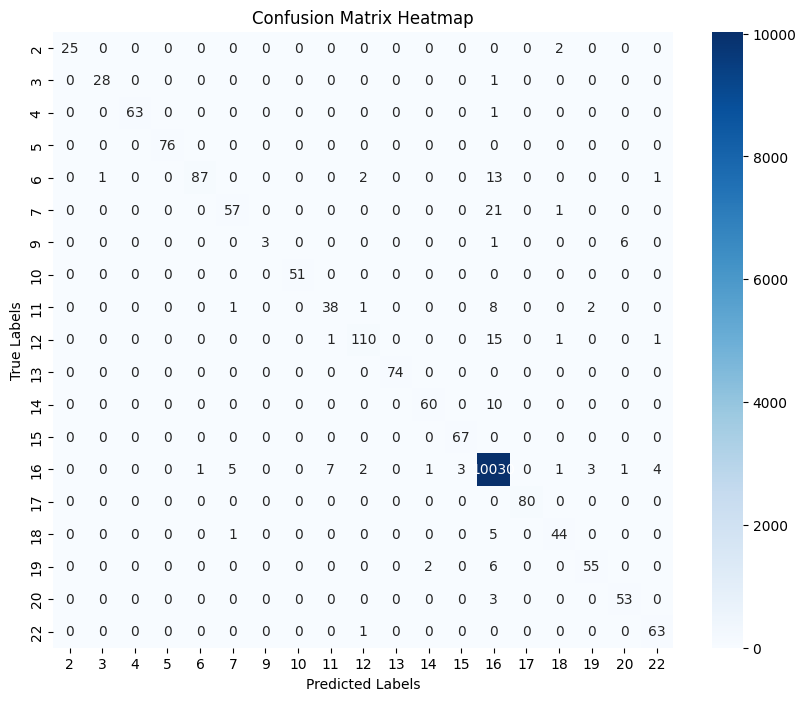

In [51]:
# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true_flat, y_pred_flat)

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_true_flat), yticklabels=np.unique(y_true_flat))

# Labels and title
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.show()

In [52]:
tag2idx

{'I-sportsteam': 2,
 'I-geo-loc': 3,
 'I-musicartist': 4,
 'B-tvshow': 5,
 'B-geo-loc': 6,
 'I-other': 7,
 'I-product': 8,
 'I-company': 9,
 'B-product': 10,
 'B-other': 11,
 'B-person': 12,
 'I-tvshow': 13,
 'I-facility': 14,
 'B-movie': 15,
 'O': 16,
 'I-movie': 17,
 'I-person': 18,
 'B-facility': 19,
 'B-company': 20,
 'B-musicartist': 21,
 'B-sportsteam': 22,
 'PAD': 0,
 'UNK': 1}

### Testing: Dataset Evaluation and Creation

In [53]:
file_path = "dataset/wnut 16test.txt.conll"
test_data  = read_conll(file_path)

In [54]:
len(test_data)

3849

In [55]:
print(test_data[0])

[('New', 'B-other'), ('Orleans', 'I-other'), ('Mother', 'I-other'), ("'s", 'I-other'), ('Day', 'I-other'), ('Parade', 'I-other'), ('shooting', 'O'), ('.', 'O'), ('One', 'O'), ('of', 'O'), ('the', 'O'), ('people', 'O'), ('hurt', 'O'), ('was', 'O'), ('a', 'O'), ('10-year-old', 'O'), ('girl', 'O'), ('.', 'O'), ('WHAT', 'O'), ('THE', 'O'), ('HELL', 'O'), ('IS', 'O'), ('WRONG', 'O'), ('WITH', 'O'), ('PEOPLE', 'O'), ('?', 'O')]


In [56]:
# Convert to a DataFrame if needed
test_df = pd.DataFrame([(token, tag) for value in test_data for token, tag in value], columns=['Token', 'Tag'])
print(test_df.head())

     Token      Tag
0      New  B-other
1  Orleans  I-other
2   Mother  I-other
3       's  I-other
4      Day  I-other


In [57]:
test_df["Tag"].value_counts(), len(test_df["Tag"].value_counts())

(Tag
 O                55941
 B-geo-loc          882
 B-company          621
 B-other            584
 I-other            556
 I-product          500
 B-person           482
 I-facility         366
 I-person           300
 I-company          265
 B-facility         253
 B-product          246
 I-geo-loc          219
 B-musicartist      191
 B-sportsteam       147
 I-musicartist      140
 I-movie             48
 I-sportsteam        48
 I-tvshow            40
 B-movie             34
 B-tvshow            33
 Name: count, dtype: int64,
 21)

In [58]:
df["Tag"].value_counts(), len(df["Tag"].value_counts())

(Tag
 O                44000
 B-person           449
 I-other            320
 B-geo-loc          276
 B-other            225
 I-person           215
 B-company          171
 I-facility         105
 B-facility         104
 B-product           97
 I-product           80
 I-musicartist       61
 B-musicartist       55
 B-sportsteam        51
 I-geo-loc           49
 I-movie             46
 I-company           36
 B-movie             34
 B-tvshow            34
 I-tvshow            31
 I-sportsteam        23
 Name: count, dtype: int64,
 21)

In [59]:
X_test = [[word2idx.get(ele[0], word2idx["UNK"]) for ele in sentence] for sentence in test_data]

# pad the sequences, to have same length
X_test = pad_sequences(
    maxlen = MAX_LEN,
    sequences = X_test,
    padding = "post",
    value = word2idx["PAD"]
)

# Convert my Tag/Label to tag_index
y_test = [[tag2idx.get(ele[1], tag2idx["UNK"]) for ele in sentence] for sentence in test_data]

# Padding each label to have same length
y_test = pad_sequences(
    maxlen = MAX_LEN,
    sequences = y_test,
    padding = "post",
    value = tag2idx["PAD"]
)

print(test_data[0])
print("Testing Sample input", X_test[0])
print("Testing Label", y_test[0])

[('New', 'B-other'), ('Orleans', 'I-other'), ('Mother', 'I-other'), ("'s", 'I-other'), ('Day', 'I-other'), ('Parade', 'I-other'), ('shooting', 'O'), ('.', 'O'), ('One', 'O'), ('of', 'O'), ('the', 'O'), ('people', 'O'), ('hurt', 'O'), ('was', 'O'), ('a', 'O'), ('10-year-old', 'O'), ('girl', 'O'), ('.', 'O'), ('WHAT', 'O'), ('THE', 'O'), ('HELL', 'O'), ('IS', 'O'), ('WRONG', 'O'), ('WITH', 'O'), ('PEOPLE', 'O'), ('?', 'O')]
Testing Sample input [3905    1    1 5355 7041 5173 8278 9446 2388 5684 1030 2973 7381 1263
  732    1 3766 9446 1543 1468    1 4078    1 4599    1 9231    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0]
Testing Label [11  7  7  7  7  7 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16
 16 16  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  

In [60]:
# Predict probabilities
y_test_pred_prob = model.predict(X_test)

121/121 [==============================] - 1s 10ms/step


In [61]:
y_test_pred_prob[0], len(y_test_pred_prob[0]), y_test_pred_prob.shape

(array([[-0.5374383 , -0.39767364, -0.6336614 , ..., -0.14264779,
         -0.5366934 , -0.13972142],
        [-0.39867145, -0.5109673 , -0.43382266, ..., -0.24962191,
         -0.7885021 , -0.2850893 ],
        [-0.72724974, -0.56613266, -0.5574774 , ..., -0.24428938,
         -0.77247155, -0.35224035],
        ...,
        [ 0.57631516, -0.02783631,  0.0026499 , ..., -0.01858024,
         -0.01993683, -0.02573788],
        [ 0.57631516, -0.02783631,  0.0026499 , ..., -0.01858024,
         -0.01993683, -0.02573788],
        [ 0.57631516, -0.02783631,  0.0026499 , ..., -0.01858024,
         -0.01993683, -0.02573788]], dtype=float32),
 75,
 (3849, 75, 23))

In [62]:
# # Convert probabilities to class predictions (for multi-class classification)
y_val_pred = np.argmax(y_test_pred_prob, axis=2)

In [63]:
y_val_pred[0], len(y_val_pred[0]), y_test[0], len(y_test[0])

(array([16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
        16, 16, 16, 16, 16, 16, 16, 16, 16,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0]),
 75,
 array([11,  7,  7,  7,  7,  7, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
        16, 16, 16, 16, 16, 16, 16, 16, 16,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0], dtype=int32),
 75)

In [64]:
y_val_pred[1], len(y_val_pred[1]), y_test[1], len(y_test[1])

(array([16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0]),
 75,
 array([16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0], dtype=int32),
 75)

In [65]:
# Convert predictions and true labels, ignoring padding tokens
y_pred_flat, y_true_flat = filter_padding(y_val_pred, y_test)

# Calculate metrics
accuracy = accuracy_score(y_true_flat, y_pred_flat)
print(f"Accuracy: {accuracy}")


Accuracy: 0.9170409051348999


In [66]:
# Classification report
print("Classification Report:")
print(classification_report(y_true_flat, y_pred_flat))

Classification Report:
              precision    recall  f1-score   support

           2       0.00      0.00      0.00        44
           3       0.06      0.02      0.03       192
           4       0.06      0.01      0.01       127
           5       0.00      0.00      0.00        31
           6       0.58      0.15      0.24       804
           7       0.24      0.04      0.07       512
           9       0.43      0.01      0.02       236
          10       0.21      0.02      0.03       220
          11       0.10      0.04      0.06       546
          12       0.31      0.15      0.20       454
          13       0.00      0.00      0.00        34
          14       0.44      0.08      0.13       324
          15       0.00      0.00      0.00        31
          16       0.93      0.99      0.96     52673
          17       0.00      0.00      0.00        44
          18       0.17      0.03      0.05       278
          19       0.09      0.03      0.05       230
    

/home/varun/Documents/MS/Business Cases/Twitter NER NLP/.twitter_venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/varun/Documents/MS/Business Cases/Twitter NER NLP/.twitter_venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/varun/Documents/MS/Business Cases/Twitter NER NLP/.twitter_venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. U

In [67]:
np.unique(y_true_flat)

array([ 2,  3,  4,  5,  6,  7,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
       20, 22], dtype=int32)

In [68]:
np.unique(y_pred_flat)

array([ 3,  4,  5,  6,  7,  9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 22])

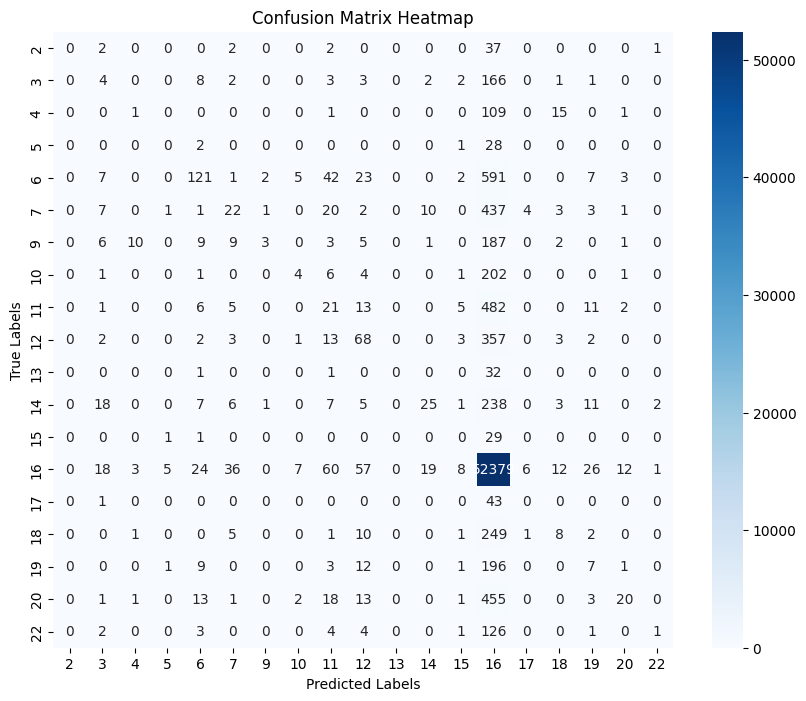

In [69]:

# Flatten the sequences and exclude padding tokens (filter padding as before)
y_pred_flat, y_true_flat = filter_padding(y_val_pred, y_test)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true_flat, y_pred_flat)

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_true_flat), yticklabels=np.unique(y_true_flat))

# Labels and title
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.show()

## Word2Vec Word Embeddings with Bi-LSTM

### Embeddings

In [70]:
len(data)

2393

In [71]:
data[0]

[('@SammieLynnsMom', 'O'),
 ('@tg10781', 'O'),
 ('they', 'O'),
 ('will', 'O'),
 ('be', 'O'),
 ('all', 'O'),
 ('done', 'O'),
 ('by', 'O'),
 ('Sunday', 'O'),
 ('trust', 'O'),
 ('me', 'O'),
 ('*wink*', 'O')]

In [72]:
for _ in range(10):
    print(data[_])

[('@SammieLynnsMom', 'O'), ('@tg10781', 'O'), ('they', 'O'), ('will', 'O'), ('be', 'O'), ('all', 'O'), ('done', 'O'), ('by', 'O'), ('Sunday', 'O'), ('trust', 'O'), ('me', 'O'), ('*wink*', 'O')]
[('Made', 'O'), ('it', 'O'), ('back', 'O'), ('home', 'O'), ('to', 'O'), ('GA', 'B-geo-loc'), ('.', 'O'), ('It', 'O'), ('sucks', 'O'), ('not', 'O'), ('to', 'O'), ('be', 'O'), ('at', 'O'), ('Disney', 'B-facility'), ('world', 'I-facility'), (',', 'O'), ('but', 'O'), ('its', 'O'), ('good', 'O'), ('to', 'O'), ('be', 'O'), ('home', 'O'), ('.', 'O'), ('Time', 'O'), ('to', 'O'), ('start', 'O'), ('planning', 'O'), ('the', 'O'), ('next', 'O'), ('Disney', 'B-facility'), ('World', 'I-facility'), ('trip', 'O'), ('.', 'O')]
[("'", 'O'), ('Breaking', 'B-movie'), ('Dawn', 'I-movie'), ("'", 'O'), ('Returns', 'O'), ('to', 'O'), ('Vancouver', 'B-geo-loc'), ('on', 'O'), ('January', 'O'), ('11th', 'O'), ('http://bit.ly/dbDMs8', 'O')]
[('@ls_n', 'O'), ('perhaps', 'O'), (',', 'O'), ('but', 'O'), ('folks', 'O'), ('may'

In [73]:
# Step 1: Preprocess the data to remove tags and extract tokens
sentences = [[word for word, tag in sentence] for sentence in data]

# Step 2: Train Word2Vec model
embedding_size = 150
word2vec_model = Word2Vec(
    sentences,
    vector_size=embedding_size,
    window=5,  # Context window size
    min_count=1,  # Include all words
    workers=4,  # Number of threads
    sg=1,  # Skip-gram model
    epochs=50  # Number of training epochs
)

# Step 3: Access word embeddings
word_embeddings = word2vec_model.wv
print(f"Vector for 'Disney': {word_embeddings['Disney']}")


Vector for 'Disney': [-0.03401573 -0.07787138  0.05246223 -0.28506628  0.02353712 -0.1624959
 -0.19079438  0.42354813  0.06821679  0.06068345  0.4157507  -0.29883167
 -0.22237596 -0.10609876  0.11701673  0.20186906  0.5043893  -0.12632003
 -0.18080994  0.04397307 -0.3651332  -0.13581058 -0.01587982  0.35307884
 -0.5621385   0.39848664 -0.56236696  0.02754335 -0.07502747 -0.502823
 -0.31107312 -0.0445449   0.03266294 -0.01730459 -0.2593072   0.2979832
  0.36678627  0.37062788 -0.09166308 -0.1251839  -0.01594435  0.26690006
 -0.21882516 -0.34856465  0.19949387 -0.07813776  0.13054474 -0.22594261
  0.05825325  0.15789446 -0.58728904  0.33159664 -0.312625    0.37511227
  0.33214206  0.05489832  0.2111212   0.29015055 -0.2504633   0.07771383
 -0.2957542  -0.35381976  0.27779567  0.11154643 -0.07416416 -0.02981466
  0.08412196 -0.44147018 -0.3652614   0.00863719  0.09326027  0.12367988
 -0.16488908 -0.37062156  0.24497145  0.3576005  -0.041061    0.05594293
 -0.11582067 -0.05303695 -0.099779

In [74]:
# Step 3: Access word embeddings
word_embeddings = word2vec_model.wv
print(f"Vector for 'home': {word_embeddings['home']}")

Vector for 'home': [-2.17520669e-02 -1.23522535e-01  4.03272778e-01 -9.50646847e-02
  2.09373888e-02 -1.03636181e+00 -7.77050614e-01  1.09794244e-01
 -2.02605486e-01 -8.28408375e-02  5.37826061e-01 -2.85710692e-01
 -4.91160899e-01 -2.24952340e-01  1.32991582e-01 -4.85456623e-02
 -3.18757147e-01 -1.36877835e-01  6.68644488e-01  1.77497491e-01
  2.53561795e-01 -3.23926061e-01  3.92769635e-01  3.52166742e-01
 -2.00121135e-01 -6.99025718e-03 -3.03980082e-01  2.58893371e-01
 -3.49489242e-01 -2.89208561e-01 -2.23292992e-01 -5.23376226e-01
  2.73092419e-01  2.97249019e-01 -1.92513317e-01  1.22791104e-01
  1.03366017e+00  2.55178511e-01 -3.76552403e-01 -1.05154049e+00
 -5.47984801e-02  3.69442284e-01 -3.77792329e-01 -3.08469027e-01
  5.65425694e-01  4.95817184e-01  4.84890461e-01 -3.94151517e-04
  2.60794550e-01  1.27608806e-01 -6.75134480e-01  3.23139697e-01
 -5.72929978e-01 -8.36640298e-02  8.04057240e-01  5.33819139e-01
  3.55098784e-01  1.79456174e-02  1.68445989e-01 -7.64750957e-01
  2.12

In [75]:
len(word_embeddings)

10585

### Features and Label, Data Splitting

In [76]:
X = [[word_embeddings[word] for word,tag in sentence] for sentence in data]

# pad the sequences, to have same length
X = pad_sequences(
    maxlen = 100,
    sequences = X,
    padding = "post",
    dtype = "float32"
)

print('Raw Sample:\n ', ' '.join([w[0] for w in data[0]]))
print('\n ' )
print('After processing, sample:\n', X[0])

Raw Sample:
  @SammieLynnsMom @tg10781 they will be all done by Sunday trust me *wink*

 
After processing, sample:
 [[-0.03880797  0.05548448 -0.13441    ...  0.11422057  0.1480474
  -0.09564422]
 [-0.01246704  0.08164434 -0.17308524 ...  0.12239877  0.19282947
  -0.12012949]
 [-0.03163513  0.22668353  0.29047447 ...  0.50402355 -0.21388218
  -0.37641183]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]


In [77]:
len(X), X.shape

(2393, (2393, 100, 150))

In [78]:
# Convert my Tag/Label to tag_index
y = [[tag2idx[ele[1]] for ele in sentence] for sentence in data]

# Padding each label to have same length
y = pad_sequences(
    maxlen = 100,
    sequences = y,
    padding = "post",
    value = tag2idx["PAD"]
)

# One-Hot encode
y = [to_categorical(i, num_classes=23) for i in y]  # n_tags+1(PAD)

print('Raw Label:\n ', ' '.join([w[1] for w in data[0]]))
print('\n ' )
print('After processing, labels:\n', y[0])

Raw Label:
  O O O O O O O O O O O O

 
After processing, labels:
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


In [79]:
len(y), len(y[0])

(2393, 100)

In [80]:
# Data Splitting

X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.1)

y_tr = np.array(y_tr)
y_te = np.array(y_te)

### Model Summary and Training

In [81]:
embedding_size = 150
def build_model(max_len=100, embedding_dim=embedding_size): # 10585 vocab size
    # Input layer to accept precomputed embeddings
    input_layer = Input(shape=(max_len, embedding_dim), name='input_layer')

    # BiLSTM layers
    lstm_output = Bidirectional(LSTM(units=50, return_sequences=True))(input_layer)
    lstm_output = Bidirectional(LSTM(units=50, return_sequences=True))(lstm_output)

    # # Dense layer
    dense_output = TimeDistributed(Dense(64, activation="relu"))(lstm_output)

    # CRF layer
    crf = CRF(23, name='crf')  # 21 classes
    predicted_sequence, potentials, sequence_length, crf_kernel = crf(dense_output)

    # Build the model
    model = Model(inputs=input_layer, outputs=potentials, name = "Twitter_NER_V1")

    # Compile the model
    model.compile(
        optimizer=AdamW(weight_decay=0.001 ,learning_rate=0.001),
        loss=SigmoidFocalCrossEntropy(),  # Use CRF-specific loss
        # loss = custom_loss,
        metrics=["accuracy"]   # Optional: Use CRF accuracy
    )

    return model

# Build and compile the model
wv_ner_model = build_model()

# Checkpointing
save_model = tf.keras.callbacks.ModelCheckpoint(filepath='wv_twitter_ner_crf.weights.h5',
  monitor='val_loss',
  save_weights_only=True,
  save_best_only=True,
  verbose=1
)

# Early stopping
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', verbose=1, patience=10)

callbacks = [save_model, es]

wv_ner_model.summary()

Model: "Twitter_NER_V1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 100, 150)]        0         
                                                                 
 bidirectional_2 (Bidirecti  (None, 100, 100)          80400     
 onal)                                                           
                                                                 
 bidirectional_3 (Bidirecti  (None, 100, 100)          60400     
 onal)                                                           
                                                                 
 time_distributed_1 (TimeDi  (None, 100, 64)           6464      
 stributed)                                                      
                                                                 
 crf (CRF)                   [(None, 100),             2070      
                              (None, 100, 23),      

In [82]:
wv_ner_model.fit(
    X_tr, y_tr, 
    validation_data = (X_te, y_te),
    batch_size=BATCH_SIZE,
    epochs=10, 
    shuffle = True)

Epoch 1/10
68/68 [==============================] - 7s 52ms/step - loss: 0.1648 - accuracy: 0.9618 - val_loss: 0.0194 - val_accuracy: 0.9872
Epoch 2/10
68/68 [==============================] - 3s 40ms/step - loss: 0.0199 - accuracy: 0.9846 - val_loss: 0.0194 - val_accuracy: 0.9849
Epoch 3/10
68/68 [==============================] - 3s 40ms/step - loss: 0.0154 - accuracy: 0.9874 - val_loss: 0.0147 - val_accuracy: 0.9881
Epoch 4/10
68/68 [==============================] - 3s 39ms/step - loss: 0.0143 - accuracy: 0.9881 - val_loss: 0.0361 - val_accuracy: 0.9883
Epoch 5/10
68/68 [==============================] - 3s 42ms/step - loss: 0.0168 - accuracy: 0.9878 - val_loss: 0.0135 - val_accuracy: 0.9887
Epoch 6/10
68/68 [==============================] - 3s 40ms/step - loss: 0.0132 - accuracy: 0.9883 - val_loss: 0.0129 - val_accuracy: 0.9887
Epoch 7/10
68/68 [==============================] - 3s 40ms/step - loss: 0.0128 - accuracy: 0.9885 - val_loss: 0.0131 - val_accuracy: 0.9891
Epoch 8/10
68

### Validation Data : Evaluation

In [83]:
# Predict probabilities
y_val_pred_prob = wv_ner_model.predict(X_te)

y_val_pred = np.argmax(y_val_pred_prob, axis=2)

8/8 [==============================] - 1s 11ms/step


In [84]:
# Convert predictions and true labels, ignoring padding tokens
y_pred_flat, y_true_flat = filter_padding(y_val_pred, np.argmax(y_te, axis=2))

# Calculate metrics
accuracy = accuracy_score(y_true_flat, y_pred_flat)
print(f"Accuracy: {accuracy}")

Accuracy: 0.9528099528099528


In [102]:
# # Classification report
# print("Classification Report:")
# print(classification_report(y_true_flat, y_pred_flat))

In [101]:
# # Compute the confusion matrix
# conf_matrix = confusion_matrix(y_true_flat, y_pred_flat)

# # Plot the heatmap
# plt.figure(figsize=(10, 8))
# sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_true_flat), yticklabels=np.unique(y_true_flat))

# # Labels and title
# plt.xlabel('Predicted Labels')
# plt.ylabel('True Labels')
# plt.title('Confusion Matrix Heatmap')
# plt.show()

### Testing Data: Evaluation

In [87]:
# Define a default (zero) embedding for OOV words
unk_embedding = np.zeros(embedding_size)

# Function to get embeddings
def get_embedding(word):
    try:
        # Access the word vector from the model
        return word_embeddings[word]
    except KeyError:
        # Return a zero vector for OOV words
        return unk_embedding
    
X_test = [[get_embedding(word) for word,tag in sentence] for sentence in test_data]

# pad the sequences, to have same length
X_test = pad_sequences(
    maxlen = 100,
    sequences = X_test,
    padding = "post",
    dtype = "float32"
)

print('Raw Sample:\n ', ' '.join([w[0] for w in test_data[0]]))
print('\n ' )
print('After processing, sample:\n', X_test[0])

Raw Sample:
  New Orleans Mother 's Day Parade shooting . One of the people hurt was a 10-year-old girl . WHAT THE HELL IS WRONG WITH PEOPLE ?

 
After processing, sample:
 [[-0.33311555 -0.0541712   0.00426361 ... -0.04001394  0.27341935
  -0.11090662]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]


In [88]:
# Convert my Tag/Label to tag_index
y_test = [[tag2idx.get(ele[1], tag2idx["UNK"]) for ele in sentence] for sentence in test_data]

# Padding each label to have same length
y_test = pad_sequences(
    maxlen = 100,
    sequences = y_test,
    padding = "post",
    dtype = "float32"
)

In [89]:
# Predict probabilities
y_test_pred_prob = wv_ner_model.predict(X_test)

# Convert probabilities to class predictions (for multi-class classification)
y_test_pred = np.argmax(y_test_pred_prob, axis=2)

121/121 [==============================] - 1s 12ms/step


In [90]:
y_test_pred_prob.shape

(3849, 100, 23)

In [91]:
y_test[0]

array([11.,  7.,  7.,  7.,  7.,  7., 16., 16., 16., 16., 16., 16., 16.,
       16., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.], dtype=float32)

In [92]:
y_test_pred[0]

array([16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
       16, 16, 16, 16, 16, 16, 16, 16,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])

In [93]:
y_test[1]

array([16., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.], dtype=float32)

In [94]:
y_test_pred[1]

array([16, 16, 16, 16, 16, 16, 16, 16,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])

In [95]:
len(y_test), len(y_test_pred)

(3849, 3849)

In [96]:
# Convert predictions and true labels, ignoring padding tokens
y_pred_flat, y_true_flat = filter_padding(y_test_pred, y_test)

# Calculate metrics
accuracy = accuracy_score(y_true_flat, y_pred_flat)
print(f"Accuracy: {accuracy}")

Accuracy: 0.9115562016547317


In [99]:
# # Classification report
# print("Classification Report:")
# print(classification_report(y_true_flat, y_pred_flat))

In [100]:
# # Compute the confusion matrix
# conf_matrix = confusion_matrix(y_true_flat, y_pred_flat)

# # Plot the heatmap
# plt.figure(figsize=(10, 8))
# sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_true_flat), yticklabels=np.unique(y_true_flat))

# # Labels and title
# plt.xlabel('Predicted Labels')
# plt.ylabel('True Labels')
# plt.title('Confusion Matrix Heatmap')
# plt.show()

## Key Observations

1. Using **Bi-LSTM with CRF**:
   - Achieved **high accuracy** on the validation dataset.
   - Results showed close to **99% accuracy** with **good recall** and **precision values** for each entity.

2. Comparison with Word2Vec Embeddings:
   - Directly using **pre-trained Word2Vec embeddings** in a neural network resulted in **lower accuracy**.
   - Incorporating a **custom embedding layer** and training on top of it yielded **better performance**.


## Questions and Answers


**Defining the problem statements, and where can this and modications of this be used?**
- We’ve finalized NER for over 25 entities that help social networking giants like Twitter, Instagram, Reddit, Inc., Pinterest, LinkedIn (the usual suspects) gather insights and boost user engagement. Because, obviously, understanding what people are posting is important.

**Explain the data format (CoNLL BIO format)**
   - The CoNLL BIO format is a common structure for annotating text data for NER tasks. Each token is assigned a label indicating whether it begins (B), is inside (I), or is outside (O) of a named entity. For example:
     ```
     Barack B-PER
     Obama I-PER
     was O
     born O
     in O
     Hawaii B-LOC
     . O
     ```

**What other NER data annotation formats are available and how are they different?**
   - **IOB**: Similar to BIO but lacks the distinction between beginning (B) and inside (I) when there is no ambiguity.
   - **BIOES**: Extends BIO by adding labels for single-token entities (S) and the end of entities (E).
   - **BILOU**: Similar to BIOES, but uses "L" for the last token of an entity and "U" for unit-length entities.

**Why do we need tokenization of the data in our case?**
   - Tokenization breaks text into manageable units (tokens) for processing. For NER, it ensures proper alignment of tokens with entity annotations, facilitating accurate tagging and model training.

**What other models can you use for this task?**
   - Alternatives include spaCy, Flair, T5, GPT-4, and custom transformer-based models.

**Did early stopping have any effect on the training and results?**
   - Early stopping prevents overfitting, especially when training on small datasets. It ensures the model generalizes better to unseen data.

**How does the BERT model expect a pair of sentences to be processed?**
   - BERT concatenates sentences with a `[SEP]` token and prepends them with a `[CLS]` token. The input is tokenized and converted into embeddings.

**Why choose attention-based models over recurrent-based ones?**
    - Attention mechanisms process all tokens simultaneously, enabling better handling of long-range dependencies and faster training. RNNs process tokens sequentially, which can be slower and less effective for long texts.

**Differentiate BERT and Simple Transformers.**
    - **BERT**: A transformer-based model pre-trained on masked language modeling and next-sentence prediction.
    - **Simple Transformers**: A Python library that simplifies the training and fine-tuning of transformer models, including BERT, for various NLP tasks.
